In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'csv' in filename:
            print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/unsw-nb15-eda/features.csv
/kaggle/input/unsw-nb15-eda/test.csv
/kaggle/input/unsw-nb15-eda/train.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv


# Introduction
* [The UNSW-NB15 dataset description](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)
* [Feature visualization and preprocessing](https://www.kaggle.com/khairulislam/unsw-nb15-eda)
* [Feature importance using RandomForest classifier](https://www.kaggle.com/khairulislam/unsw-nb15-feature-importance)
* [Performance with other classifiers](https://www.kaggle.com/khairulislam/unsw-nb15-anomaly-detection)

# Utils

In [2]:
def input_train_test():
    root = '../input/unsw-nb15/'
    train = pd.read_csv(root+'UNSW_NB15_training-set.csv')
    test = pd.read_csv(root+'UNSW_NB15_testing-set.csv')
    
    if train.shape[0] == 82332:
        print("Train and test sets are reversed here. Fixing them.")
        train, test = test, train
    drop_columns = ['attack_cat', 'id']
    for df in [train, test]:
        for col in drop_columns:
            if col in df.columns:
                print('Dropping '+col)
                df.drop([col], axis=1, inplace=True)
    return train, test

def get_cat_columns(train):
    categorical = []
    for col in train.columns:
        if train[col].dtype == 'object':
            categorical.append(col)
    return categorical
    
def label_encode(train, test):
    for col in get_cat_columns(train):
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))
    return train, test

def feature_process(df):
    df.loc[~df['state'].isin(['FIN', 'INT', 'CON', 'REQ', 'RST']), 'state'] = 'others'
    df.loc[~df['service'].isin(['-', 'dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']), 'service'] = 'others'
    df.loc[df['proto'].isin(['igmp', 'icmp', 'rtp']), 'proto'] = 'igmp_icmp_rtp'
    df.loc[~df['proto'].isin(['tcp', 'udp', 'arp', 'ospf', 'igmp_icmp_rtp']), 'proto'] = 'others'
    return df

def get_train_test(train, test, feature_engineer=True, label_encoding=False, scaler=None):
    x_train, y_train = train.drop(['label'], axis=1), train['label']
    x_test, y_test = test.drop(['label'], axis=1), test['label']
    
    x_train, x_test = feature_process(x_train), feature_process(x_test)
    if scaler is not None:
        categorical_columns = get_cat_columns(x_train)
        non_categorical_columns = [x for x in x_train.columns if x not in categorical_columns]
        x_train[non_categorical_columns] = scaler.fit_transform(x_train[non_categorical_columns])
        x_test[non_categorical_columns] = scaler.transform(x_test[non_categorical_columns])
    
    if label_encoding:
        x_train, x_test = label_encode(x_train, x_test)
        features = x_train.columns
    else:
        x_train = pd.get_dummies(x_train)
        x_test = pd.get_dummies(x_test)
        print("Column mismatch {0}, {1}".format(set(x_train.columns)- set(x_test.columns),  set(x_test.columns)- set(x_train.columns)))
        features = list(set(x_train.columns) & set(x_test.columns))
    print(f"Number of features {len(features)}")
    x_train = x_train[features]
    x_test = x_test[features]

    return x_train, y_train, x_test, y_test

def run_lgb(x, y, tr_idx, val_idx, param, num_round=100):
    lgb_train = lgb.Dataset(x.iloc[tr_idx], y.iloc[tr_idx])
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    validation = lgb.Dataset(x_val, y_val)
    clf = lgb.train(param, lgb_train, num_round, valid_sets=[validation], early_stopping_rounds=50, verbose_eval=200, feval=lgb_f1_score)
    return clf

def false_alarm_rate(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)
    TN, FN, TP, FP = CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    return (FP+FN)/(TP+TN+FP+FN)

def results(y_test, y_prob):
    threshold = 0.5
    y_pred = np.where(y_prob >= threshold, 1, 0)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred) # it is also called detection rate or true positive rate
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"Acc {acc}, Precision {pre}, Recall {rec}, F1-score {f1}")
    
    CM = metrics.confusion_matrix(y_test, y_pred)
    TN, FN, TP, FP = CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    # false positive rate
    FPR = FP/(FP+TN)
    # false alarm rate 
    FAR = (FP+FN)/(TP+TN+FP+FN)
    AUC = metrics.roc_auc_score(y_test, y_prob)
    
    print("FPR {0}, FAR {1}, AUC {2}".format(FPR, FAR, AUC))
    # print(metrics.classification_report(y_test, y_pred))
    
def test_run(x_train, y_train, x_test, y_test, param, num_round=2000):
    start = time.clock()
    
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_validation = lgb.Dataset(x_test, y_test)
    clf = lgb.train(param, lgb_train, num_round, valid_sets=[lgb_validation], early_stopping_rounds=50, verbose_eval=200, feval=lgb_f1_score)
    # clf = lgb.train(param, lgb_train, 2000, valid_sets=[lgb_validation], early_stopping_rounds=50, verbose_eval=200)
    y_prob = clf.predict(x_test, num_iteration=clf.best_iteration)
    
    print()
    results(y_test, y_prob)
    print("Time spent {0}".format(time.clock() - start))
    return y_prob
    
def cross_validation(X, Y, param, kf, num_round=2000):
    start = time.clock()
    y_probs = []
    y_vals = []

    # for tr_idx, val_idx in tqdm(kf.split(X, Y), total=folds):
    for tr_idx, val_idx in kf.split(X, Y):
        clf = run_lgb(X, Y, tr_idx, val_idx, param, num_round)
        x_val, y_val = X.iloc[val_idx], Y.iloc[val_idx]
        y_prob = clf.predict(x_val, num_iteration=clf.best_iteration)
        
        y_probs.extend(y_prob)
        y_vals.extend(y_val)

    print()
    results(y_vals, np.asarray(y_probs))
    print("Time spent {0}".format(time.clock() - start))

In [3]:
train, test = input_train_test()

Train and test sets are reversed here. Fixing them.
Dropping attack_cat
Dropping id
Dropping attack_cat
Dropping id


# Train data

In [4]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

def lgb_accuracy(preds, data):
    y_true = data.get_label()
    y_pred = np.round(preds)
    return 'acc', metrics.accuracy_score(y_true, y_pred), True

def lgb_f1_score(preds, data):
    y_true = data.get_label()
    y_pred = np.round(preds) # scikits f1 doesn't like probabilities
    return 'f1', metrics.f1_score(y_true, y_pred), True

In [5]:
folds = 10
seed = 1
num_round = 2000
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

start = time.clock() 
drop_columns = ['is_sm_ips_ports', 'dwin', 'is_ftp_login', 'trans_depth', 'dttl', 'ct_ftp_cmd']
for df in [train, test]:
    df.drop(drop_columns, axis=1, inplace=True)
x_train, y_train, x_test, y_test = get_train_test(train, test, feature_engineer=True, label_encoding=False, scaler=StandardScaler())
print("Time spent in total preprocessing {0} s".format(time.clock() - start))

Column mismatch set(), set()
Number of features 54
Time spent in total preprocessing 4.759016 s


In [6]:
param = {
    'objective': 'binary', 
    'learning_rate': 0.1, 
    "boost_from_average":True,
    "metric": 'binary_logloss' # 'auc'
}
start = time.clock()
# test_run( x_train, y_train, x_train, y_train, param)
clf = lgb.train(param, lgb.Dataset(x_train, y_train), 2000, valid_sets=[lgb.Dataset(x_train, y_train)], early_stopping_rounds=50, verbose_eval=200)
y_prob = clf.predict(x_train, num_iteration=clf.best_iteration)
print()
results(y_train, y_prob)
print("Time spent {0}".format(time.clock() - start))

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0776548
[400]	valid_0's binary_logloss: 0.0636346
[600]	valid_0's binary_logloss: 0.0536225
[800]	valid_0's binary_logloss: 0.0459373
[1000]	valid_0's binary_logloss: 0.0396676
[1200]	valid_0's binary_logloss: 0.0345212
[1400]	valid_0's binary_logloss: 0.0303571
[1600]	valid_0's binary_logloss: 0.026872
[1800]	valid_0's binary_logloss: 0.0237827
[2000]	valid_0's binary_logloss: 0.0211797
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.0211797

Acc 0.9961161394083529, Precision 0.9953495750329788, Recall 0.998960960608676, F1-score 0.9971519979925977
FPR 0.009946428571428571, FAR 0.0038838605916471335, AUC 0.999927484806443
Time spent 268.59143


In [7]:
y_prob = clf.predict(x_test, num_iteration=clf.best_iteration)
print()
results(y_test, y_prob)


Acc 0.8688116406743429, Precision 0.8191345816158666, Recall 0.9775875761051795, F1-score 0.8913740910965172
FPR 0.2644594594594595, FAR 0.1311883593256571, AUC 0.9809944714192707


## Ten-fold cross validation

After dropping irrelevant columns, feature engineering and applying oneHotEncoding. We found among different scaling StandardScaler is performing the best.

|Preprocess| Param | Accuracy |F1-score |
|:---:|:---:|:---:|:---:|:---:|:---:|
|RobustScaler|learning rate 0.05|96.11| 97.16|
||learning rate 0.1|95.19| 97.22|
||learning rate 0.3|95.73| 96.88|
|StandardScaler |learning rate 0.05|96.08| 97.14 |
||learning rate 0.1| 96.20 | 97.23|
||learning rate 0.3| 95.71 | 96.87|
|MinMaxScaler |learning rate 0.05|96.08| 97.14
| |learning rate 0.1|96.20|97.22 

In [8]:
param = {
    'objective': 'binary', 
    'learning_rate': 0.1, 
    "boost_from_average":True,
    "metric": 'binary_logloss' # 'auc'
}
cross_validation(x_train, y_train, param, kf)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0929967	valid_0's f1: 0.96977
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0870685	valid_0's f1: 0.970869
[400]	valid_0's binary_logloss: 0.0819235	valid_0's f1: 0.972575
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.0825926	valid_0's f1: 0.972861
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0928118	valid_0's f1: 0.969198
[400]	valid_0's binary_logloss: 0.088741	valid_0's f1: 0.970967
Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.0883625	valid_0's f1: 0.971624
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0882203	valid_0's f1: 0.970273
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.0878964	valid_0's f1: 0.970211
Training until validation scores 

## Five-fold cross validation

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cross_validation(x_train, y_train, param, kf)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0891891	valid_0's f1: 0.969969
[400]	valid_0's binary_logloss: 0.0850312	valid_0's f1: 0.971909
Early stopping, best iteration is:
[455]	valid_0's binary_logloss: 0.0845862	valid_0's f1: 0.972279
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0918073	valid_0's f1: 0.969483
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.0887961	valid_0's f1: 0.970875
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.089209	valid_0's f1: 0.970017
[400]	valid_0's binary_logloss: 0.0848384	valid_0's f1: 0.972391
Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.0849441	valid_0's f1: 0.972494
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0905414	valid_0's f1: 0.9708
[400]	valid_0's binary_logloss: 0.0864308	valid_0's f1: 0.97204
Early

# Test data

In [10]:
param = {
    'objective': 'binary', 
    'learning_rate': 0.1, 
    "boost_from_average":True,
    "metric": 'binary_logloss' # 'auc'
}
y_prob = test_run(x_test, y_test, x_test, y_test, param)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0361828	valid_0's f1: 0.988951
[400]	valid_0's binary_logloss: 0.0203956	valid_0's f1: 0.995678
[600]	valid_0's binary_logloss: 0.0123723	valid_0's f1: 0.99861
[800]	valid_0's binary_logloss: 0.00774753	valid_0's f1: 0.999382
[1000]	valid_0's binary_logloss: 0.00493171	valid_0's f1: 0.999614
[1200]	valid_0's binary_logloss: 0.0031983	valid_0's f1: 0.99979
Early stopping, best iteration is:
[1236]	valid_0's binary_logloss: 0.00294144	valid_0's f1: 0.999801

Acc 0.9997813729777001, Precision 0.9997132774591971, Recall 0.9998897026383129, F1-score 0.999801482265749
FPR 0.00035135135135135135, FAR 0.00021862702229995628, AUC 0.99999988105771
Time spent 249.51189699999986


## Validate on test data
Here the model trained on test data is being validated using test data.

|Param|Accuracy|F1-score|
|:---:|:---:|:---:|:---:|
|learning_rate 0.1 | 87.74 | 89.87
|learning_rate 0.05 | 87.60 | 89.77
|learning_rate 0.1, is_unbalance True | 91.87 | 92.9
|learning_rate 0.05, is_unbalance True | 91.95 | 92.96

In [11]:
param = {
    'objective': 'binary',
    'learning_rate': 0.05, 
    'boost_from_average':True,
    'is_unbalance':True,
    "metric": 'binary_logloss' # 'auc'
}
y_prob = test_run(x_train, y_train, x_test, y_test, param)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.1853	valid_0's f1: 0.929638

Acc 0.9194845260651995, Precision 0.8958900186166404, Recall 0.9660284126003706, F1-score 0.9296381603388068
FPR 0.13754054054054055, FAR 0.08051547393480056, AUC 0.9864868024735227
Time spent 37.99111300000004


[[31911  5089]
 [ 1540 43792]]


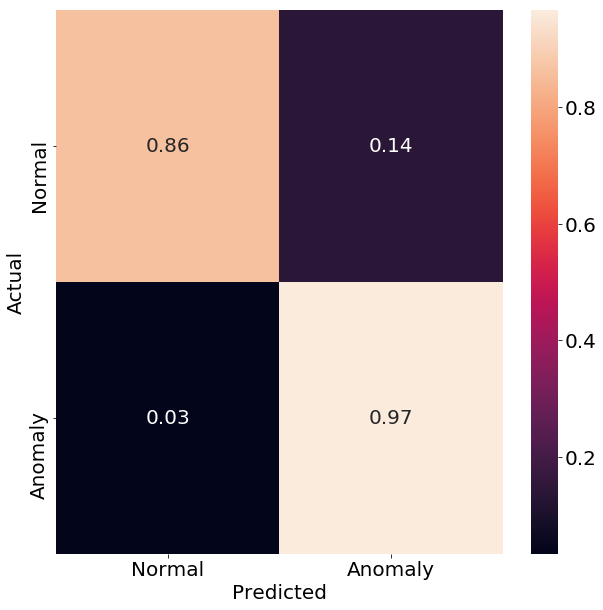

In [12]:
y_pred = np.where(y_prob >= 0.5, 1, 0)
print(metrics.confusion_matrix(y_test, y_pred))

target_names = ['Normal', 'Anomaly']
cm = metrics.confusion_matrix(y_test, y_pred)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rc('font', size=20) 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)

plt.ylabel('Actual')
plt.xlabel('Predicted')
 
plt.show(block=False)

## Ten-fold cross validation

|Param|Accuracy| F1-score|
|:---:|:---:|:---:|
|learning_rate 0.05| 98.07 | 98.24
|learning_rate 0.1| 98.18 | 98.34
|learning_rate 0.3| 98.08 | 98.25
|learning_rate 0.1, feature_fraction 0.5 | 98.14 | 98.30
|learning_rate 0.05, feature_fraction 0.5| 98.04 | 98.21


In [13]:
param = {
    'objective': 'binary',
    'learning_rate': 0.1, 
    "boost_from_average":True,
    # 'is_unbalance':True,
    # "feature_fraction":0.5,
    "metric": 'binary_logloss' # 'auc'
}
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cross_validation(x_test, y_test, param, kf, num_round=2000)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0482127	valid_0's f1: 0.983017
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.0459499	valid_0's f1: 0.985022
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0568795	valid_0's f1: 0.980466
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.0544355	valid_0's f1: 0.982016
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0522023	valid_0's f1: 0.981842
Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.0514076	valid_0's f1: 0.982953
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0516532	valid_0's f1: 0.982339
Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.0477933	valid_0's f1: 0.984906
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0

## Five-fold cross validation

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cross_validation(x_test, y_test, param, kf)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0535638	valid_0's f1: 0.981693
[400]	valid_0's binary_logloss: 0.0493049	valid_0's f1: 0.983088
Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.0495075	valid_0's f1: 0.983421
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0533186	valid_0's f1: 0.982038
Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.0515242	valid_0's f1: 0.983376
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.0513647	valid_0's f1: 0.982215
[400]	valid_0's binary_logloss: 0.0470931	valid_0's f1: 0.983674
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.0471132	valid_0's f1: 0.983784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0583507	valid_0's f1: 0.980977
Training until validation score

# Combined data
Here we combined both train and test set. Then evaluated their ten-fold cross validation performance.

In [15]:
total = pd.concat([train, test], axis=0)
X, Y = total.drop(['label'], axis=1), total['label']
categorical_columns = get_cat_columns(X)
non_categorical_columns = [col for col in X.columns if col not in categorical_columns]
X = feature_process(X)
X[non_categorical_columns] = StandardScaler().fit_transform(X[non_categorical_columns])
X = pd.get_dummies(X)

| Param | Accuracy | F1-score
|:---:|:---:|:---:|
|learning rate 0.05 | 95.11 | 96.15
|learning rate 0.01 | 93.69 | 95.07
|learning rate 0.1 | 95.09 | 96.07
|learning rate 0.1, is_unbalance True | 95.16 | 96.19
|learning rate 0.1, bagging_fraction 0.8 | 95.14 | 96.17
|learning rate 0.1, feature_fraction 0.5 | 95.20 | 96.22
|learning rate 0.1, feature_fraction 0.5, bagging_fraction 0.8 | 95.05 | 96.11

In [16]:
param = {
    'objective': 'binary',
    'learning_rate': 0.1, 
    "boost_from_average":True,
    # 'is_unbalance':True,
    # "bagging_fraction":0.8,
    "feature_fraction":0.5,
    # "bagging_freq":1,
    "metric": 'binary_logloss' # 'auc'
}
cross_validation(X, Y, param, kf, num_round=2000)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.108583	valid_0's f1: 0.958986
[400]	valid_0's binary_logloss: 0.104327	valid_0's f1: 0.961015
Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.104327	valid_0's f1: 0.961015
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.108378	valid_0's f1: 0.95867
[400]	valid_0's binary_logloss: 0.104467	valid_0's f1: 0.961183
[600]	valid_0's binary_logloss: 0.102306	valid_0's f1: 0.962104
[800]	valid_0's binary_logloss: 0.100991	valid_0's f1: 0.962723
Early stopping, best iteration is:
[901]	valid_0's binary_logloss: 0.100696	valid_0's f1: 0.963265
Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.109639	valid_0's f1: 0.958035
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.106194	valid_0's f1: 0.960779
Training until validation scores don't improve for 50 rounds
[200]	valid_